In [112]:
import subprocess
import os
import numpy as np
import rasterio
import folium
from matplotlib import cm
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from datetime import datetime
import re
from scipy import interpolate


In [117]:
loc = "lon38_5671lat9_2948"
locGroup = "79_Ethiopia"
bucket = "p79ethiopia65"
country="Ethiopia"

GEEproject="p155mali2"
repl_pkg_path = r"C:\Users\tillmanv\Dropbox\MarketActivityIndex\mai_shared\Submissions\MktAct\NatureComm\ReplicationPackage"

# PAUL - node and ee-runner into requirements
#nodePath = str(subprocess.check_output(["which node"], shell=True))[2:-3]
#eerunnerPath = str(subprocess.check_output(["which ee-runner"], shell=True))[2:-3]

nodePath = "/root/.nvm/versions/node/v23.3.0/bin/node"
eerunnerPath = "/root/.nvm/versions/node/v23.3.0/bin/ee-runner"

The GEE code in the following cell takes as inputs the outlines of the candidate location and the downloaded imagery to produce a .tif file where each band represents the intensity of apperance differences on average across the images in the sample by day-of-week, against their respective reference composites. Running this code requires access to the proprietary imagery as well as a GEE account. We therefore provide the output of the code and visualize it in a subsequent cell. 

In [ ]:
# Define the path to the input file
file_path = f"{repl_pkg_path}/code\\data_derivation\\01_prep.txt"

# Read the content of the input file
with open(file_path, "r") as file:
    content = file.read()

# Replace placeholders in the file content with actual variable values
content = (content.replace("INSERT_LOC_HERE", loc)
                  .replace("INSERT_LOC_GROUP_HERE", locGroup)
                  .replace("INSERT_BUCKET_HERE", bucket)
                  .replace("INSERT_COUNTRY_HERE", country))

# Define the path for the new file with "_torun" suffix
new_file_path = file_path.replace(".txt", "_torun.txt")

# Write the updated content to the new file
with open(new_file_path, "w") as new_file:
    new_file.write(content)

# Execute the updated script using Node.js and the ee-runner tool
subprocess.call([
    nodePath,                # Path to the Node.js executable
    eerunnerPath,            # Path to the ee-runner script
    new_file_path,           # Path to the updated script file
    f"--project={GEEproject}"  # Specify the GEE project as a command-line argument
])


FileNotFoundError: [WinError 2] The system cannot find the file specified

C:\Users\tillmanv\AppData\Local\Temp\ipykernel_17132\3228531420.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  rgba[mask, :3] = (cm.get_cmap(cmap_name)(arr[mask])[:, :3] * 255).astype(np.uint8)  # Apply colormap



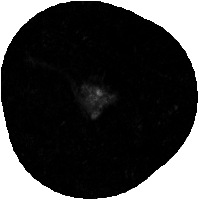
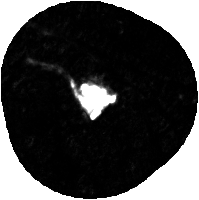

In [57]:
# Define the path to the difference image file
diffImg_path = os.path.join(repl_pkg_path, "datasets", "intermediate_outputs", f"{loc}_diffImg.tif")

# Open the difference image using rasterio
with rasterio.open(diffImg_path) as src:
    # Extract band names and image bounds
    band_names = src.descriptions
    bounds = src.bounds

    # Calculate the center latitude and longitude for the map
    center_lat = (bounds.top + bounds.bottom) / 2
    center_lon = (bounds.left + bounds.right) / 2

    # Initialize a folium map centered at the calculated location
    m = folium.Map(location=[center_lat, center_lon], zoom_start=18, tiles='CartoDB positron')

    # Function to convert a band to RGBA format using a colormap
    def rgba_from_band_01(band, cmap_name='gray', vmin=None, vmax=None):
        arr = np.ma.filled(band, np.nan).astype(float)  # Replace masked values with NaN
        arr = np.clip((arr - vmin) / (vmax - vmin), 0.0, 1.0)  # Normalize to [0, 1]
        rgba = np.zeros((*arr.shape, 4), dtype=np.uint8)  # Initialize RGBA array
        mask = ~np.isnan(arr)  # Mask for valid data
        rgba[mask, :3] = (cm.get_cmap(cmap_name)(arr[mask])[:, :3] * 255).astype(np.uint8)  # Apply colormap
        rgba[mask, 3] = 255  # Set alpha channel for valid data
        return rgba

    # Loop through the first two bands and add them as overlays to the map
    for i in range(1, 3):
        band = src.read(i, masked=True)  # Read the band as a masked array
        rgba = rgba_from_band_01(band, 'gray', vmin=0, vmax=5)  # Convert to RGBA
        folium.raster_layers.ImageOverlay(
            image=rgba,
            bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
            name=f"Day-of-week {i-1} ({['Sunday', 'Monday'][i-1]})",  # Add a descriptive name
            opacity=1,  # Set overlay opacity
        ).add_to(m)

    # Add a satellite tile layer and a layer control to the map
    folium.TileLayer('Esri.WorldImagery', name='Satellite').add_to(m)
    folium.LayerControl().add_to(m)

# Display the map
m

After completing 01_prep, we can now extract the shapes with periodic appearance differences using 02_mktShape.txt

In [ ]:
# Define the path to the input file
file_path = f"{repl_pkg_path}/code\\data_derivation\\02_mktShape.txt"

# Read the content of the input file
with open(file_path, "r") as file:
    content = file.read()

# Replace placeholders in the file content with actual variable values
content = (content.replace("INSERT_LOC_HERE", loc)
                  .replace("INSERT_LOC_GROUP_HERE", locGroup)
                  .replace("INSERT_BUCKET_HERE", bucket)
                  .replace("INSERT_COUNTRY_HERE", country))

# Define the path for the new file with "_torun" suffix
new_file_path = file_path.replace(".txt", "_torun.txt")

# Write the updated content to the new file
with open(new_file_path, "w") as new_file:
    new_file.write(content)

# Execute the updated script using Node.js and the ee-runner tool
subprocess.call([
    nodePath,                # Path to the Node.js executable
    eerunnerPath,            # Path to the ee-runner script
    new_file_path,           # Path to the updated script file
    f"--project={GEEproject}"  # Specify the GEE project as a command-line argument
])


The following cell presents the output.

In [41]:
# Define the path to the shapefile
shapefile_path = os.path.join(
    repl_pkg_path, 
    "datasets", 
    "intermediate_outputs", 
    f"{locGroup}_shapes_shp_MpM6_{locGroup}{loc}.shp"
)

# Load the shapefile using GeoPandas
gdf = gpd.read_file(shapefile_path)

# Filter rows where 'subStrictn' equals 100 (removes rings for visualization purposes)
gdf = gdf[gdf['subStrictn'] == 100]

# Filter the GeoDataFrame to keep:
# 1. Shapes with the smallest 'strictness' for each 'weekdayShp'
# 2. Shapes with 'strictness' values that are multiples of four
idx_min_strictness = gdf.groupby('weekdayShp')['strictness'].idxmin()
idx_multiple_of_four = gdf[gdf['strictness'] % 4 == 0].index
combined_indices = pd.Index(idx_min_strictness).union(pd.Index(idx_multiple_of_four))
gdf = gdf.loc[combined_indices]

# Assign a color to each unique value of 'strictness' based on its rank
strictness_colors = {
    value: cm.get_cmap('viridis')(rank / len(strictness_values))
    for rank, value in enumerate(sorted(strictness_values))
}

# Sort the GeoDataFrame by 'weekdayShp' (ascending) and 'strictness' (descending)
gdf = gdf.sort_values(by=['weekdayShp', 'strictness'], ascending=[True, False])

# Calculate the centroid of the shapefile's geometry to center the map
centroid = gdf.geometry.unary_union.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=18, tiles='CartoDB positron')

# Add the shapes to the map with colors based on 'strictness'
for _, row in gdf.iterrows():
    color = f"#{int(strictness_colors[row['strictness']][0] * 255):02x}" \
            f"{int(strictness_colors[row['strictness']][1] * 255):02x}" \
            f"{int(strictness_colors[row['strictness']][2] * 255):02x}"
    folium.GeoJson(
        data=row['geometry'],
        name=f"Weekday {int(row['weekdayShp'])}, Strictness {row['strictness']}",
        style_function=lambda x, color=color: {'color': color, 'weight': 2, 'fillOpacity': 0.5}
    ).add_to(m)

# Add a satellite tile layer and a layer control to the map
folium.TileLayer('Esri.WorldImagery', name='Satellite').add_to(m)
folium.LayerControl().add_to(m)

# Display the map
m

C:\Users\tillmanv\AppData\Local\Temp\ipykernel_36000\267159856.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  value: cm.get_cmap('viridis')(rank / len(strictness_values))
C:\Users\tillmanv\AppData\Local\Temp\ipykernel_36000\267159856.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.geometry.unary_union.centroid


If there is at least one shape in the output 02_mktShape that is associated with StrictnessRank<20 (the threshold shown in Fig. 2), or if the detected shape is manually assessed to identify a marketplace despite higher values of StrictnessRank, we execute the following step, 03_actPrep. This step generates a .tif where each band represents the appearance differences by captured image in the area covered by the detected shape. This data will subsequently be exported as a CSV for further processing. Note that at this point, we hanve't determined yet which of the detected shapes represents the actual market. 

In [42]:
# Define the path to the input file
file_path = f"{repl_pkg_path}/code\\data_derivation\\03_actPrep.txt"

# Read the content of the input file
with open(file_path, "r") as file:
    content = file.read()

# Replace placeholders in the file content with actual variable values
content = (content.replace("INSERT_LOC_HERE", loc)
                  .replace("INSERT_LOC_GROUP_HERE", locGroup)
                  .replace("INSERT_BUCKET_HERE", bucket)
                  .replace("INSERT_COUNTRY_HERE", country))

# Define the path for the new file with "_torun" suffix
new_file_path = file_path.replace(".txt", "_torun.txt")

# Write the updated content to the new file
with open(new_file_path, "w") as new_file:
    new_file.write(content)

# Execute the updated script using Node.js and the ee-runner tool
subprocess.call([
    nodePath,                # Path to the Node.js executable
    eerunnerPath,            # Path to the ee-runner script
    new_file_path,           # Path to the updated script file
    f"--project={GEEproject}"  # Specify the GEE project as a command-line argument
])

# Note: The resulting image is stored in datasets/intermediate_outputs/{loc}_actPrep.tif")


FileNotFoundError: [WinError 2] The system cannot find the file specified

The final steps in GEE converts the output from 03_actPrep into a CSV and export a second CSV with the properties of each of the images, such as cloud cover or acquisition time.

In [ ]:
# Define the path to the input file
file_path = f"{repl_pkg_path}/code\\data_derivation\\04_activity.txt"

# Read the content of the input file
with open(file_path, "r") as file:
    content = file.read()

# Replace placeholders in the file content with actual variable values
content = (content.replace("INSERT_LOC_HERE", loc)
                  .replace("INSERT_LOC_GROUP_HERE", locGroup)
                  .replace("INSERT_BUCKET_HERE", bucket)
                  .replace("INSERT_COUNTRY_HERE", country))

# Define the path for the new file with "_torun" suffix
new_file_path = file_path.replace(".txt", "_torun.txt")

# Write the updated content to the new file
with open(new_file_path, "w") as new_file:
    new_file.write(content)

# Execute the updated script using Node.js and the ee-runner tool
subprocess.call([
    nodePath,                # Path to the Node.js executable
    eerunnerPath,            # Path to the ee-runner script
    new_file_path,           # Path to the updated script file
    f"--project={GEEproject}"  # Specify the GEE project as a command-line argument
])

# Define the path to the input file
file_path = f"{repl_pkg_path}/code\\data_derivation\\04a_properties.txt"

# Read the content of the input file
with open(file_path, "r") as file:
    content = file.read()

# Replace placeholders in the file content with actual variable values
content = (content.replace("INSERT_LOC_HERE", loc)
                  .replace("INSERT_LOC_GROUP_HERE", locGroup)
                  .replace("INSERT_BUCKET_HERE", bucket)

# Define the path for the new file with "_torun" suffix
new_file_path = file_path.replace(".txt", "_torun.txt")

# Write the updated content to the new file
with open(new_file_path, "w") as new_file:
    new_file.write(content)

# Execute the updated script using Node.js and the ee-runner tool
subprocess.call([
    nodePath,                # Path to the Node.js executable
    eerunnerPath,            # Path to the ee-runner script
    new_file_path,           # Path to the updated script file
    f"--project={GEEproject}"  # Specify the GEE project as a command-line argument
])


We now analyze the exported series of appearance differences for each ring to identify the market's fringe. Using this information, we construct the activity measure as the series of activity differences within the identified fringe.

market_days_ [1, 5]


C:\Users\tillmanv\AppData\Local\Temp\ipykernel_36000\2274906995.py:196: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  first_row_index = (result['p75_nonmktDays_sum'] > result['p50_mktDays_sum']).replace(False, pd.NA).idxmax()
C:\Users\tillmanv\AppData\Local\Temp\ipykernel_36000\2274906995.py:196: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  first_row_index = (result['p75_nonmktDays_sum'] > result['p50_mktDays_sum']).replace(False, pd.NA).idxmax()
C:\Users\tillmanv\AppData\Local\Temp\ipykernel_36000\2274906995.py:246: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

,image_id,weekdayThisAreaIsActive,date,mktDay,mktID,year,month,weekday,mkt_lat,mkt_lon,time_decimal,sumsum_maxpMax_27_100,sumsum_maxpMax_27_24,sumsum_maxpMax_30_100,sumsum_maxpMax_30_28,acquired,anomalous_pixels,clear_confidence_percent,clear_percent,cloud_cover,cloud_percent,heavy_haze_percent,instrument,light_haze_percent,satellite_azimuth,satellite_id,shadow_percent,sun_azimuth,sun_elevation,view_angle,visible_confidence_percent,visible_percent,median_time,diff_to_median_time,exclDates,maxVar_s_1_maxpMax,maxVar_s_5_maxpMax,activity_measure,activity_measure_mean_nonmktday,activity_measure_mean0,activity_measure_mean0_mean_mktday,activity_measure_norm,act_weekly,activity_metric,Location
acquired,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-12-28 07:06:27.230536+00:00,20161228_070627_0e0e_3B,1,2016-12-28,0,lon38_5671lat9_2948,2016,12,3,9.2948,38.5671,7.107500,0.647233,0.387900,0.724155,0.639522,2016-12-28 07:06:27.230536+00:00,0.00,86.0,100.0,0.0,0.0,0.0,PS2,0.0,226.2,0e0e,0.0,134.0,42.7,0.1,86.0,100.0,7.352778,0.245278,1,sumsum_maxpMax_30_28,sumsum_maxpMax_27_24,0.724155,0.659566,0.064589,6.601124,0.978452,0.978452,sumsum_maxpMax_30_28,lon38_5671lat9_2948
2016-12-29 07:07:41.721440+00:00,20161229_070741_0e16_3B,1,2016-12-29,0,lon38_5671lat9_2948,2016,12,4,9.2948,38.5671,7.128056,0.743525,0.532417,0.788876,0.610816,2016-12-29 07:07:41.721440+00:00,0.00,82.0,100.0,0.0,0.0,0.0,PS2,0.0,217.5,0e16,0.0,134.0,42.8,0.1,82.0,100.0,7.352778,0.224722,1,sumsum_maxpMax_30_28,sumsum_maxpMax_27_24,0.788876,0.659566,0.129309,6.601124,1.958898,1.958898,sumsum_maxpMax_30_28,lon38_5671lat9_2948
2017-01-07 07:06:55.395894+00:00,20170107_070655_0e0e_3B,1,2017-01-07,0,lon38_5671lat9_2948,2017,1,6,9.2948,38.5671,7.115278,0.496102,0.310061,0.526427,0.403913,2017-01-07 07:06:55.395894+00:00,0.00,85.0,100.0,0.0,0.0,0.0,PS2,0.0,208.2,0e0e,0.0,132.2,42.5,0.8,85.0,100.0,7.352778,0.237500,1,sumsum_maxpMax_30_28,sumsum_maxpMax_27_24,0.526427,0.659566,-0.133139,6.601124,-2.016912,-2.016912,sumsum_maxpMax_30_28,lon38_5671lat9_2948
2017-01-12 07:06:59.703901+00:00,20170112_070659_0e0e_3B,1,2017-01-12,0,lon38_5671lat9_2948,2017,1,4,9.2948,38.5671,7.116389,0.444209,0.303893,0.521576,0.478654,2017-01-12 07:06:59.703901+00:00,0.01,85.0,100.0,0.0,0.0,0.0,PS2,0.0,199.9,0e0e,0.0,131.1,42.6,0.8,85.0,100.0,7.352778,0.236389,1,sumsum_maxpMax_30_28,sumsum_maxpMax_27_24,0.521576,0.659566,-0.137990,6.601124,-2.090406,-2.090406,sumsum_maxpMax_30_28,lon38_5671lat9_2948
2017-01-14 07:08:09.391048+00:00,20170114_070809_0e0f_3B,1,2017-01-14,0,lon38_5671lat9_2948,2017,1,6,9.2948,38.5671,7.135833,0.806360,0.724348,0.866802,0.662036,2017-01-14 07:08:09.391048+00:00,0.01,83.0,100.0,0.0,0.0,0.0,PS2,0.0,39.2,0e0f,0.0,130.7,42.8,0.9,83.0,100.0,7.352778,0.216944,1,sumsum_maxpMax_30_28,sumsum_maxpMax_27_24,0.866802,0.659566,0.207236,6.601124,3.139408,3.139408,sumsum_maxpMax_30_28,lon38_5671lat9_2948


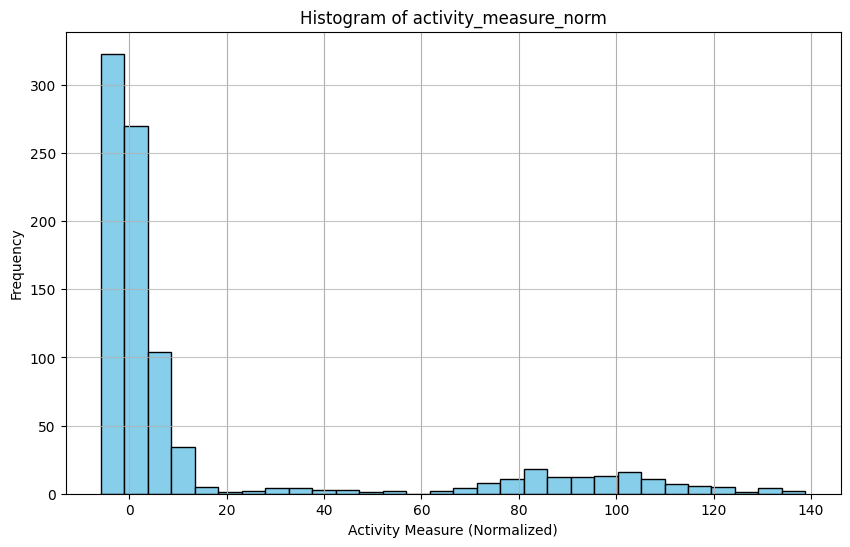

market_days_ [1, 5]


C:\Users\tillmanv\Dropbox\MarketActivityIndex\mai_shared\Submissions\MktAct\NatureComm\ReplicationPackage\code\data_derivation\05_activityFunctions.py:196: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  first_row_index = (result['p75_nonmktDays_sum'] > result['p50_mktDays_sum']).replace(False, pd.NA).idxmax()
C:\Users\tillmanv\Dropbox\MarketActivityIndex\mai_shared\Submissions\MktAct\NatureComm\ReplicationPackage\code\data_derivation\05_activityFunctions.py:196: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  first_row_index = (result['p75_nonmktDays_sum'] > result['p50_mktDays_sum']).replace(False, pd.NA).idxmax()
C:\Users\tillmanv\Dropbox\MarketActivityIndex\mai_shared\Submissions\MktAct\NatureComm\ReplicationPackage\code\data_derivation\05_activityFunctions.py:246: Se

Series([], Name: count, dtype: int64)


C:\Users\tillmanv\Dropbox\MarketActivityIndex\mai_shared\Submissions\MktAct\NatureComm\ReplicationPackage\code\data_derivation\05_activityFunctions.py:256: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_nonmktday = allActivity[allActivity['mktDay']==0].groupby(['weekdayThisAreaIsActive', 'instrument'], group_keys=False).apply(lambda g: interval_mean(g, 'activity_measure'))
C:\Users\tillmanv\Dropbox\MarketActivityIndex\mai_shared\Submissions\MktAct\NatureComm\ReplicationPackage\code\data_derivation\05_activityFunctions.py:262: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be 

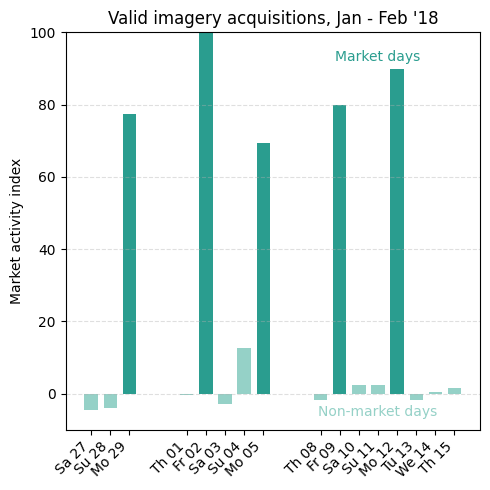

In [124]:
file_path = f"{repl_pkg_path}/code\\data_derivation\\05_activityFunctions.py"
%run -i "$file_path"

# Import all functions from the specified file path
spec = importlib.util.spec_from_file_location("activityFunctions", file_path)
activityFunctions = importlib.util.module_from_spec(spec)
spec.loader.exec_module(activityFunctions)

# Pass notebook variables to the module's namespace
activityFunctions.__dict__.update(globals())


# Upload activity data for the specified location
df = activity_processor(loc, bucket, locGroup, repl_pkg_path)

# Convert Stata daily date numeric to datetime if necessary
if not np.issubdtype(df['date'].dtype, np.datetime64):
    df['date'] = pd.to_datetime(df['date'], unit='D', origin='1960-01-01')

# Add market code and ID columns
df['mktid'] = loc

# Define the target date and range for filtering
target = pd.Timestamp('2018-02-05')
rng = 10

# Filter the dataframe for the target date range, valid activity measures, and specific instrument
df1 = df[
    df['date'].between(target - pd.Timedelta(days=rng), target + pd.Timedelta(days=rng))
    & df['activity_measure_norm'].notna()
    & (df['instrument'] == 'PS2')
].copy()

# Count market-day observations per market
df1['countMktDayObs'] = df1.groupby('mktid')['mktDay'].transform('sum')

# Print the count of markets with exactly 4 market-day observations
print(df1.loc[df1['countMktDayObs'] == 4, 'mktid'].value_counts())

# Filter for rows where mktDay is either 0 (non-market day) or 1 (market day)
df1 = df1[df1['mktDay'].isin([0, 1])].copy()

# Create a two-letter weekday + day-of-month label (e.g., "Mo 05")
dow2 = df1['date'].dt.day_name().map({
    'Monday': 'Mo', 'Tuesday': 'Tu', 'Wednesday': 'We',
    'Thursday': 'Th', 'Friday': 'Fr', 'Saturday': 'Sa', 'Sunday': 'Su'
})
df1['date_text2'] = dow2 + ' ' + df1['date'].dt.strftime('%d')

# Drop duplicate rows based on market ID and date, and sort by date
df1 = df1.drop_duplicates(subset=['mktid', 'date']).sort_values('date')

# Plot bar chart for market activity on non-market vs market days
fig, ax = plt.subplots(figsize=(5, 5))

# Define colors for non-market and market days
c_non = '#95d1c7'  # Light green
c_mkt = '#2a9d8f'  # Dark green

# Separate data for non-market and market days
d0 = df1[df1['mktDay'] == 0]
d1 = df1[df1['mktDay'] == 1]

# Plot bars for non-market and market days
ax.bar(d0['date'], d0['activity_measure_norm'], width=0.7, color=c_non, label='Non-market days')
ax.bar(d1['date'], d1['activity_measure_norm'], width=0.7, color=c_mkt, label='Market days')

# Set plot title and labels
ax.set_title("Valid imagery acquisitions, Jan - Feb '18")
ax.set_xlabel('')
ax.set_ylabel('Market activity index')

# Add grid lines for the y-axis
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Set x-axis tick labels to the two-letter weekday + day format
ax.set_xticks(df1['date'])
ax.set_xticklabels(df1['date_text2'], rotation=45, ha='right')

# Set y-axis limits to match the range in Stata
ax.set_ylim(-10, 100)

# Add annotations near the left side of the plot
left_x = df1['date'].max() - pd.Timedelta(days=4)
ax.text(left_x, -7, "Non-market days", color=c_non, ha='center', va='bottom')
ax.text(left_x, 95, "Market days", color=c_mkt, ha='center', va='top')

# Remove the legend for a cleaner plot
ax.legend().remove()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()